# CONTROLLABILITY


In [1]:
!pip install -q tellurium
!pip install -q controlSBML


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
  DEPRECATION: future is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [24]:
import tellurium as te
import controlSBML as ctl
import numpy as np
import matplotlib.pyplot as plt

# Helpers

In [3]:
TEST_MODEL = """
S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 3
k1 = 1
k2 = 1
S2 = 0
"""

In [44]:
# Function that adjust model parameters
def plotModel(model, title="", is_plot=True, input_species=None, times=np.linspace(0, 5, 50), selections=None, figsize=(4,4), **kwargs):
    """
    Plots the simulation with the specified parameter values.
    
    Parameters
    ----------
    model: str either antimony or URL
    title: str (plot title)
    is_plot: bool
    input_species: str (species used as input if it is not a boundary/fixed species in the model)
    times: array-float (times for simulations)
    selections: list-str (species to plot)
    figsize: int, int (dimensions of the figure)
    kwargs: dict
        key: parameter name
        value: parameter value
    
    Returns
    -------
    NamedArray
    """
    if "http" in model:
        rr = te.loadSBMLModel(model)
    else:
        rr = te.loada(model)
    if input_species is not None:
        rr.setBoundary(input_species, True)
    if selections is not None:
        new_selections = list(selections)
        if not "time" in selections:
            new_selections.insert(0, "time")
    else:
        new_selections = selections
    for name, value in kwargs.items():
        rr[name] = value
    simulation_results = rr.simulate(times[0], times[-1], len(times), selections=new_selections)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        columns = simulation_results.colnames
        columns = columns[1:]
        for column in columns:
            if column == "time":
                next
            ax.plot(simulation_results[:, 0], simulation_results[column])
        plt.legend(columns)
        ax.set_xlabel("time")
    return simulation_results
    
# TESTS
results = plotModel(TEST_MODEL, input_species="S1", figsize=(4,4), is_plot=False)
assert("NamedArray" in str(type(results)))
print("OK")

OK


# Controllability

Consider a system with input $u(t)$ and output $y(t)$ that we want to regulate over the region $y_L \leq y(t) \leq y_H$. The system is controllable if there are values of $u(t)$ such that $y(t)$ can achieve the desired values.

In [5]:
MODEL1 = """
S1 -> S2; k1*S1
S2 -> ; k2*S2

$S1 = 2
k1 = 0.5
k2 = 1.1
S2 = 0
"""

Find $S_1$ that produces $S_2 = 3$

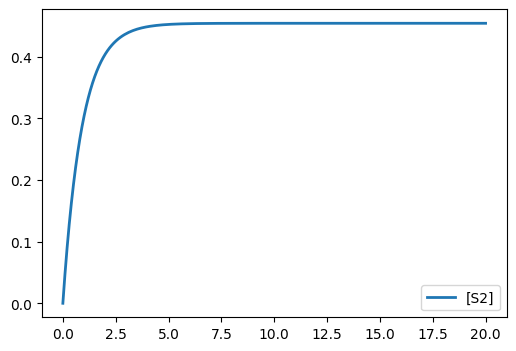

In [6]:
_ = plotModel(MODEL1, times=np.linspace(0, 20, 200), S1=1)

Not all systems are controllable.

In [7]:
MODEL2 = """
S1 -> S2; k1*S1/(1 + S1)
S2 -> ; k2*S2
$S1 = 0
k1 = 0.5
k2 = 1.1
S2 = 0
"""

Find a value of S1 that results in S2 = 2.

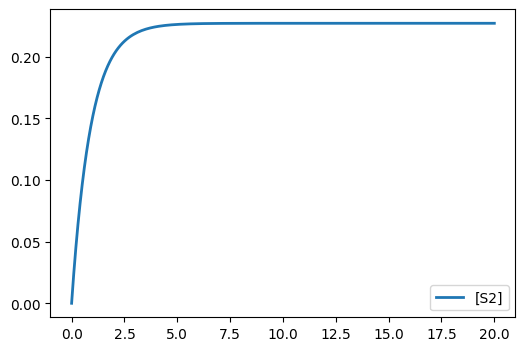

In [8]:
_ = plotModel(MODEL2, times=np.linspace(0, 20, 200), S1=1)

## mTOR Case Study



<img src="mtor.png"
     alt="Markdown Monster icon" 
     width="1000" height="1200"
     style="float: left; margin-right: 10px;" />

In [9]:
# mTOR model
MTOR_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1909250003/2/Varusai2018.xml"

Problem: What are the names of the species?

In [10]:
rr = te.loadSBMLModel(MTOR_URL)
rr.getFloatingSpeciesIds()

['IR',
 'pIR',
 'IRS',
 'pIRS',
 'iIRS',
 'Akt',
 'pAkt',
 'mTORC1',
 'pmTORC1',
 'mTORC2',
 'pmTORC2',
 'imTORC2',
 'mTORC1_DEPTOR',
 'mTORC2_DEPTOR',
 'DEPTOR',
 'pDEPTOR']

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/lectures/lecture_05-controllability/mtor.png" width="300" height="225" /></a>


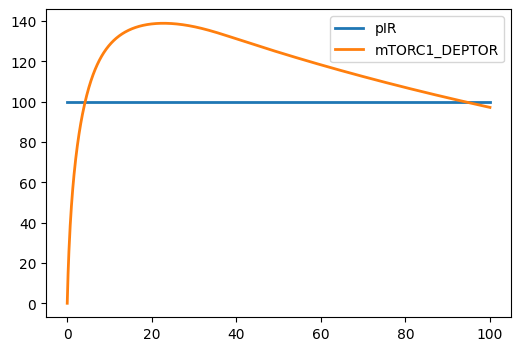

In [11]:
_ = plotModel(MTOR_URL,  input_species="pIR", selections=["pIR", "mTORC1_DEPTOR"], pIR=100, times=np.linspace(0, 100, 1000))

# Evaluating Controllability

Look at the response to the input over a series of steps. The series of steps is called a **staircase**. A staircase has an initial value, a final value, and a number of steps. This is implemented by using Antimony **events**. An event is a statement executed once when a condition is true. We condition on the variable **time**.

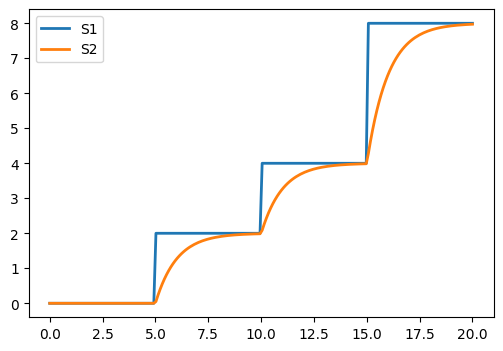

In [20]:
MODEL1A = """
model *main();
S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 0
k1 = 1
k2 = 1
S2 = 0

// Events to create a staircase function of the input
at time > 0: S1 = 0
at time > 5: S1 = 2
at time > 10: S1 = 4
at time > 15: S1 = 8
end
"""
_ = plotModel(MODEL1A, times=np.linspace(0, 20, 200), input_species="S1", selections=["S1", "S2"])

This model has an operating region in which $S_1 \in [0, 8]$. That is, this range of input values elicit a significant change in the output $S_2$.

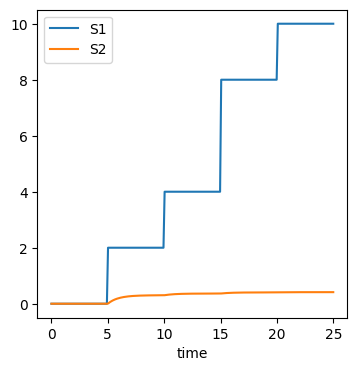

In [34]:
MODEL2A = """
model *main();
S1 -> S2; k1*S1/(1 + S1)
S2 -> ; k2*S2
$S1 = 0
k1 = 0.5
k2 = 1.1
S2 = 0

// Events to create a staircase function of the input
at time > 0: S1 = 0
at time > 5: S1 = 2
at time > 10: S1 = 4
at time > 15: S1 = 8
at time > 20: S1 = 10
end
"""
_ = plotModel(MODEL2A, times=np.linspace(0, 25, 250), input_species="S1", selections=["S1", "S2"], figsize=(4,4))

The operating region for this model is much smaller than the previous model. So, we need to adjust the staircase.

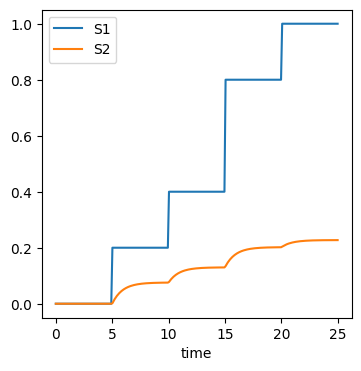

In [40]:
MODEL2B = """
model *main();
S1 -> S2; k1*S1/(1 + S1)
S2 -> ; k2*S2
$S1 = 0
k1 = 0.5
k2 = 1.1
S2 = 0

// Events to create a staircase function of the input
at time > 0: S1 = 0
at time > 5: S1 = 0.2
at time > 10: S1 = 0.4
at time > 15: S1 = 0.8
at time > 20: S1 = 1
end
"""
_ = plotModel(MODEL2B, times=np.linspace(0, 25, 250), input_species="S1", selections=["S1", "S2"], figsize=(4,4))

## Operating Region

The operating region of a system is the range of input values over which the output values have a significant and predictable change.

# ControlSBML

In [14]:
MODEL4 = """
model *main();
S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 0
k1 = 1
k2 = 1
S2 = 0
end
"""

## Constructor

In [15]:
ctlsb = ctl.ControlSBML(MODEL4, input_names=["S1"], output_names=["S2"], is_fixed_input_species=True)

## Staircase

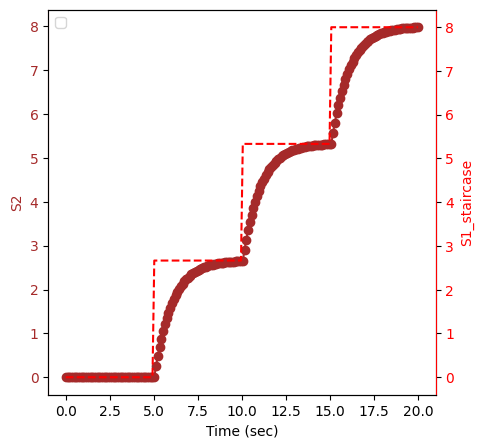

In [16]:
_, builder = ctlsb.plotStaircaseResponse(initial_value=0, final_value=8, num_step=3, times=np.linspace(0, 20, 200))

In [17]:
builder

// Created by libAntimony v2.13.2
model *main()

  // Compartments and Species:
  species S1, S2;

  // Reactions:
  _J0: S1 -> S2; k1*S1;
  _J1: S2 -> ; k2*S2;

  // Species initializations:
  S1 = 0;
  S2 = 0;

  // Variable initializations:
  k1 = 1;
  k2 = 1;

  // Other declarations:
  const k1, k2;

//vvvvvvvvvAdded by ControlSBMLvvvvvvvvvv
const S1

// Staircase: S1->S2
S1 = 0.000000
at (time>= 0.0): S1 = 0.0
at (time>= 5.025125628140704): S1 = 2.6666666666666665
at (time>= 10.050251256281408): S1 = 5.333333333333333
at (time>= 15.075376884422111): S1 = 8.0
//^^^^^^^^^Added by ControlSBML^^^^^^^^^^
end

## Closed loop system

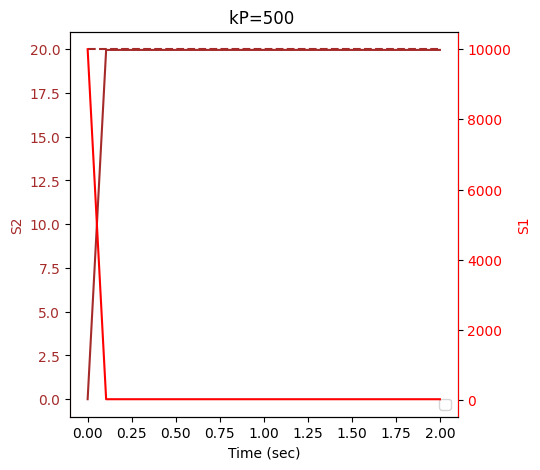

In [45]:
_, builder = ctlsb.plotClosedLoop(setpoint=20, kP=500, times=np.linspace(0, 2, 20))

In [46]:
builder

// Created by libAntimony v2.13.2
model *main()

  // Compartments and Species:
  species S1, S2;

  // Reactions:
  _J0: S1 -> S2; k1*S1;
  _J1: S2 -> ; k2*S2;

  // Species initializations:
  S1 = 0;
  S2 = 0;

  // Variable initializations:
  k1 = 1;
  k2 = 1;

  // Other declarations:
  const k1, k2;

//vvvvvvvvvAdded by ControlSBMLvvvvvvvvvv
const S1

// Closed loop: S1 -> S2

// Make sinusoid: amplitude=0, frequency=20
noise_S1_S2_ot := 0.000000*sin(2*pi*20.000000*time)

// Make sinusoid: amplitude=0, frequency=20
disturbance_S1_S2_ot := 0.000000*sin(2*pi*20.000000*time)

// Filter: kf=None
filter_S1_S2_ot := filter_S1_S2_in

// PI Controller: kp=500, ki=None
controller_integral_error_S1_S2' = controller_S1_S2_in
controller_integral_error_S1_S2 = 0
controller_S1_S2_ot := 500.000000*controller_S1_S2_in
control_error_S1_S2_ot := 20 - filter_S1_S2_ot

// Connect the elements of the closed loop
controller_S1_S2_in := control_error_S1_S2_ot
S1 := controller_S1_S2_ot + disturbance_S1_S

## mTOR Case Study

In [47]:
CTLSB = ctl.ControlSBML(MTOR_URL)

In [48]:
print(CTLSB.getPossibleOutputs())

floating_species:	IR, pIR, IRS, pIRS, iIRS, Akt, pAkt, mTORC1, pmTORC1, mTORC2, pmTORC2, imTORC2, mTORC1_DEPTOR, mTORC2_DEPTOR, DEPTOR, pDEPTOR

parameter:	V1, Km1, V2, Km2, k3c, Km3, V4, Km4, k5ca, Km5a, k5cb, Km5b, V6, Km6, k7c, Km7, V8, Km8, k9c, Km9, V10, Km10, k11ca, Km11a, k11cb, Km11b, V12, Km12, k13f, k13r, k14f, k14r, k15c, Km15, V16, Km16, ks17, kd18

reaction:	v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15, v16, v17, v18


In [49]:
CTLSB = ctl.ControlSBML(MTOR_URL, input_names=["pIR"], output_names=["mTORC1_DEPTOR"], is_fixed_input_species=True)

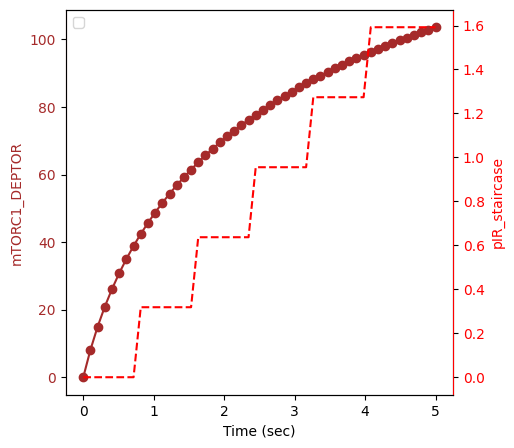

In [50]:
#_ = CTLSB.plotStaircaseResponse(final_value=50, times=np.linspace(0, 20000, 200000))
_ = CTLSB.plotStaircaseResponse()

In [51]:
_ = CTLSB.plotClosedLoop(setpoint=40, kP=1)
#_ = CTLSB.plotClosedLoop(setpoint=40, kp=1, times=np.linspace(0, 2000, 20000), sign=1)

Error: CVODE Error: CV_TOO_MUCH_WORK, Module: CVODES, Function: CVode, Message: At t = 2.2573, mxstep steps taken before reaching tout.


RuntimeError: CVODE Error: CV_TOO_MUCH_WORK: The solver took mxstep (20000) internal steps but could not reach tout.; In virtual double rr::CVODEIntegrator::integrate(double, double)